In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy as np

# gerrychain imports
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept
from gerrychain.constraints import (Validator, single_flip_contiguous,
                                    within_percent_of_ideal_population, UpperBound)
from functools import partial

In [2]:
# State specific variables
state = "LA" # Louisiana
num_districts = 39 # senate districts
data_path = "./LA_data/LA_data.json"
pop_varname = "TOTPOP"
bvap_varname = "BVAP"
vap_varname = "VAP"
num_markov_steps = 100 # in Markov chain

In [3]:
# load the graph
graph = Graph.from_json(data_path)

In [4]:
def get_ideal_population(graph, pop_varname, num_districts):
    tot_pop = 0
    for i in range(len(graph.nodes)):
        tot_pop += graph.nodes[i][pop_varname]
        
    return int(tot_pop/num_districts)

ideal_population = get_ideal_population(graph, pop_varname, num_districts)

In [5]:
updaters = {"population": updaters.Tally(pop_varname, alias="population"),
            "bvap":updaters.Tally(bvap_varname, alias='bvap'),
            "vap":updaters.Tally(vap_varname, alias='vap'),
           }

In [6]:
####################################################################################
################ Build Initial Partition and Markov Chain ##########################
####################################################################################


## Build the initial partition

# assign each node to a district in a dict of the form {node: district}
seed_partition_dict = recursive_tree_part(graph, range(39), pop_col=pop_varname,
                                     pop_target=ideal_population,
                                     epsilon=0.01, node_repeats=1)

# use the partition dictionary to build a Partition object
seed_partition = GeographicPartition(graph, assignment=seed_partition_dict, updaters=updaters)

## Build the Markov chain
tree_proposal = partial(recom,
                       pop_col=pop_varname,
                       pop_target=ideal_population,
                       epsilon=0.05,
                       node_repeats=1
                      )

# Constraints
def increase_opportunity_districts(proposal_partition):
    opp_percent = 0.35
    if partition.parent is None:
        return True
    
    curr_opp_dists = 0
    prev_opp_dists = 0
    for i in range(num_districts):
        curr_bvap_percent = partition["bvap"][i] / partition["vap"][i]
        prev_bvap_percent = partition.parent["bvap"][i] / partition.parent["vap"][i]
        
        if curr_bvap_percent >= opp_percent:
            curr_opp_dists += 1
        if prev_bvap_percent >= opp_percent:
            prev_opp_dists += 1
             
    if curr_opp_dists >= prev_opp_dists:
        return True
    else:
        return False
    
popbound = within_percent_of_ideal_population(seed_partition, .1)

recom_chain = MarkovChain(tree_proposal, Validator([popbound]), accept=increase_opportunity_districts,
                          initial_state=seed_partition, total_steps=num_markov_steps)

In [10]:
time = []
steps = 0

num_opp_dist_list = []
opp_percent = 0.35

for partition in recom_chain:
    curr_opp_dists = 0
    for i in range(num_districts):
        bvap_percent = partition["bvap"][i] / partition["vap"][i]
        if bvap_percent >= opp_percent:
            curr_opp_dists += 1
    
    num_opp_dist_list.append(curr_opp_dists)
    time.append(steps)
    steps += 1

print(time)
print(num_opp_dist_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 13, 13, 13, 12, 11, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 12, 12, 13, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


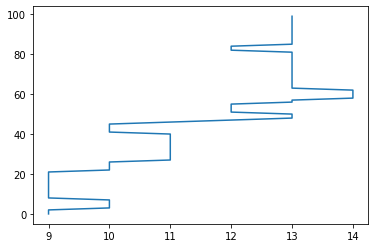

In [8]:
plt.plot(num_opp_dist_list, time)

    

In [ ]:
len(graph.nodes)